# Computing BAT flux upper limits from rate data w/ the NITRATES responses
All the results are here: https://drive.google.com/drive/u/0/folders/1a4bldN4rO_TxyR_lQUAO5_qJFG9ePG50. \
NITRATES response files are here: https://drive.google.com/drive/u/0/folders/1jzdiIzbKzmeiwF6NrTl-7bhUEeT7I_w1. \
Author: MC, heavily based on JDL code\
Created: Apr 18, 2022\
Last update: Apr 25, 2022\
List of updates:
- (Apr 25): bi-linear extrapolation between grid points in the detector plane

To-do's (discuss in the meeting, Apr 25):
1. No updates on tasks below except for the grid ID flux consideration.

To-do's (discuss in the meeting, Apr 18): 
<font color='gray'>
1. Discuss which data formats Aaron and Jimmy use in their code and change accordingly. 
    - file names are different, make sure that divided directories are within the considered time interval, better adapt to the public data.
2. Automate the code & clean it up (unused var & imports, debugging prints, wrap the script w functions, passwords & pep-8)
    - (?) No repeated tasks?
    - (?) Include different spectral shapes (soft, hard?)
    - (?) Adjust the duration considered (currently [t0-1, t0+30])
    - (?) Which lc binning to use?
    Make them all parameters. 
3. What results do we need to save?
    - Upper limits (at injected position? 
    - Structuring the code: general function with above parameters, (iterating over different parameters)-->output whatever the input was 
    - image plane do bi-linear extrapolation between grid points --> then project it on the sky
    
</font> 


### Steps:

#### 1. Check BAT FoV
_Given the LVC probability map, check for the overlapping regions between the GW event and the BAT FoV. Save spacecraft information @ time of trigger (sky coverage, Earth position)._ This is BAT tools.
#### 2. Raw lightcurve analysis
_Extract the raw lightcurves from the BAT FoV (64 ms, 1 s, and 1.6 s). Considering [T0-1 s, T0+30 s], we calculate the standard deviation. This could be easily changed?_
#### 3. Upper limit calculation
Assuming the Band function with the normal spectral hardness, we compute the expected number of counts for a 5-sigma detection in the energy range [15 keV, 350 keV]. This spectrum is then passeed through the NITRATES response functions for different grid IDs to compute the observed flux for different positions in the detector plane. 
#### 4. Results
Two different maps are reported: 1) 2-point linear extrapolation between the most and least sensitive flux limits, and 2) different values in different parts of the sky.


<font color='red'>Note that in this notebook, I assume that steps 1) and 2) are done. This might require some modification in the code, as I download all of the data from BAT machines.</font> 

Put all this together in an exe script. 

In [4]:
# standard packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits as pyfits
import healpy as hp
from kapteyn import maputils
import sys, os

# BAT UL functions
sys.path.append('/Users/mcrnogor/Desktop/Swift-GBM/scripts/') # path to the functions script
from calc_BAT_ul import *

%matplotlib inline

/Users/mcrnogor/opt/anaconda3/lib/python3.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [5]:
# loading the necessary files

event = 'S190413a'
bat_info = "example/S190413a/info.txt"
lc_path = "example/S190413a/1s_rate_sort.lc" # here using the 1-s light curve
bat_img = "example/S190413a/batfov.fits"
# !cat {bat_info}

# Parsing the info.txt file:
lines = open(bat_info).readlines()
t0 = float(lines[5].split()[-1]) # LIGO trigger time
earth_ra = float(lines[11].split()[-1])
earth_dec = float(lines[12].split()[-1])
earth_rad = 69. # Earth radius for Swift BAT
bat_ra = float(lines[13].split()[-1]) # BAT RA at t0
bat_dec = float(lines[14].split()[-1]) # BAT Dec at t0

# Light curve manipulation 
lc_1s = pyfits.open(lc_path)
counts_1s = lc_1s[1].data['COUNTS']
time_1s = lc_1s[1].data['TIME'] - t0
rate_1s = counts_1s # for the 1-second time bin

# Considering the light curve from -1 to 30 seconds to match GBM search window
index = [i for i,x in enumerate(time_1s) if x>=-1 and x<=30]
time_new = time_1s[index]
counts_new = counts_1s[index]
rate_new = rate_1s[index]
std = np.std(rate_new)

In [6]:
# Flux upper-limit calculation

Ndets_tot = 32768.0 # total dets
Ndets_active = float(lines[16].split()[-1]) # current number of active dets
Ndet_ratio = Ndets_active / Ndets_tot

# Considering different Grid IDs 
IDs = [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33] # the std of rates from the LC
rate_upper_limit = 5*std 
# print("5sigma rate upper limit: ", rate_upper_limit)

ul_5sigma = [] 
for i in IDs:
    grid_id = i 
    # print("grid_id: ", grid_id)

    # using energy bin 15-350 and ignoring 350-500
    chan_low = 0 
    chan_hi = 3

    # getting the NITRATES DRM table
    drm_tab = get_drm_tab(grid_id)

    # response matrix using selected energy bins and corrected for number of active dets
    drm_matrix = drm_tab['MATRIX'][:,chan_low:(chan_hi+1)] * Ndet_ratio 

    # find the flux that gives an expected rate equal to the rate upper limit
    flux_upper_limit = rate2band_eflux(rate_upper_limit, drm_matrix,\
                                    drm_tab['ENERG_LO'], drm_tab['ENERG_HI'],\
                                    alpha, beta, Epeak, flux_elo, flux_ehi)
    #print("5-sigma flux upper limit [erg/cm2/s]: ", flux_upper_limit)
    ul_5sigma.append(flux_upper_limit)

/Users/mcrnogor/opt/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/Users/mcrnogor/opt/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/Users/mcrnogor/opt/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

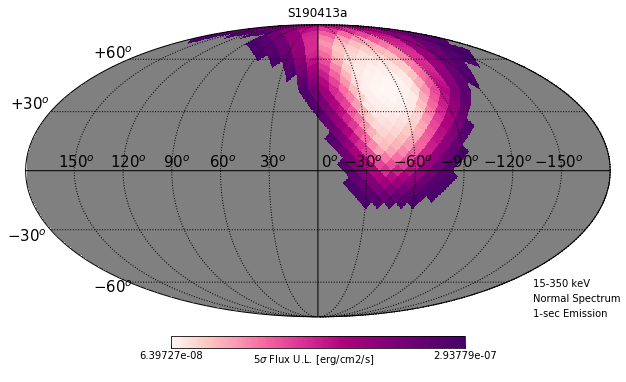

<Figure size 432x288 with 0 Axes>

In [7]:
ul_min = ul_5sigma[12]
ul_max = ul_5sigma[15]

# plotting the BAT FoV
res = .25
nra = int(360. / res)
ndec = int(180. / res)

header = {'NAXIS'  : 2, 'NAXIS1': nra, 'NAXIS2': ndec,
'CTYPE1' : 'RA---MOL',
'CRVAL1' : bat_ra, 'CRPIX1' : int(.5 * nra), 'CUNIT1' : 'deg', 'CDELT1' : -0.25,
'CTYPE2' : 'DEC--MOL',
'CRVAL2' : bat_dec, 'CRPIX2' : int(.5 * ndec), 'CUNIT2' : 'deg', 'CDELT2' : 0.25,
      }

fits = maputils.FITSimage(bat_img, hdunr=0).reproject_to(header)

# producing a healpy map
nside = 12 # as GBM
npix = hp.nside2npix(nside)
val = np.zeros(npix, np.float64)
th, ph = hp.pix2ang(nside, np.arange(npix))
ra, dec = np.degrees([ph, .5 * np.pi - th])

i, j = fits.proj.topixel((ra, dec))
val = fits.dat[j.astype(int), i.astype(int)]


# this is first pass at the scaling between min and max flux ul

vmax = val[~np.isnan(val)].max()
vmin = val[~np.isnan(val)].min()
k = (ul_max - ul_min)/(vmax - vmin)
m = ul_max - k*vmax
val = k*val+m # rescale FOV map as an upper limit map
val[np.isnan(val)] = hp.UNSEEN
val[np.isnan(val)] = hp.UNSEEN
# print("Min: %.3e" % val[val > hp.UNSEEN].min())
# print("Max: %.3e" % val[val > hp.UNSEEN].max())

Earth_limb_region_x = []
Earth_limb_region_y = []

# mask out the Earth
earth_vec = hp.ang2vec(np.radians(90. - earth_dec), np.radians(earth_ra))
earth_pix = hp.query_disc(nside, earth_vec, np.radians(earth_rad))
val[earth_pix] = hp.UNSEEN
plt.figure()
hp.mollview(val, rot=0, fig=3, norm='log', cmap='RdPu', title=event)
hp.graticule()
plt.annotate(r"0$^o$", (0.02, 0.02), size=15)
plt.annotate(r"-30$^o$", (0.31, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"30$^o$", (-0.31, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"-60$^o$", (0.65, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"60$^o$", (-0.65, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"-90$^o$", (0.97, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"90$^o$", (-0.97, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"-120$^o$", (1.30, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"120$^o$", (-1.30, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"-150$^o$", (1.65, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"150$^o$", (-1.65, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"+30$^o$", (-1.97,  0.45), horizontalalignment='center', verticalalignment='center', size=15)
plt.annotate(r"-30$^o$", (-1.99, -0.45), horizontalalignment='center', verticalalignment='center', size=15)
plt.annotate(r"+60$^o$", (-1.40,  0.80), horizontalalignment='center', verticalalignment='center', size=15)
plt.annotate(r"-60$^o$", (-1.40, -0.80), horizontalalignment='center', verticalalignment='center', size=15)
zlabel = r"5$\sigma$ Flux U.L. [erg/cm2/s]"
plt.annotate(zlabel, (0.5, 0.05), horizontalalignment='center', size=10, xycoords='figure fraction')
plt.annotate("15-350 keV", (.85, .25), size=10, xycoords='figure fraction')
plt.annotate("Normal Spectrum", (.85, .21), size=10, xycoords='figure fraction')
plt.annotate("1-sec Emission", (.85, .17), size=10, xycoords='figure fraction')
plt.figure()

What do I need?
1. What data do I need? Concatenate x,y- detector coordinates with their corresponding upper limits
2. bi-linear extrapolation across the grid (decide on # of pts)
3. Project onto the sky plane

In [8]:
# 1. Define bi-linear extrapolation in the det plane
def bilinear_extrarpolation(x, y, points):
    '''Extrapolate (x,y) from values associated with four points.

    The four points are a list of four triplets:  (x, y, value); four 
    points should form a rectangle.
    The four points can be in any order.  They should form a rectangle.
    '''
    
    points = sorted(points)               # order points by x, then by y
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('points do not form a rectangle')
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError('(x, y) not within the rectangle')

    return (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)
           ) / ((x2 - x1) * (y2 - y1) + 0.0)

In [9]:
# test
n = [(-1.00000000e+00, -7.00000000e-01, 2.74774525e-07),
     (-5.00000000e-01, -7.00000000e-01, 1.68539312e-07),
     (-1.00000000e+00, -3.50000000e-01, 1.25126663e-07),
     (-5.00000000e-01, -3.50000000e-01, 8.09279226e-08),]
bilinear_extrarpolation(-0.6, -0.6, n)

1.612095877657143e-07

In [10]:
# # 2. What data do I need? Concatenate x,y- detector coordinates with their corresponding upper limit 

# gridID_coord = np.loadtxt('grid_theta_phi_table.txt')
# L = (gridID_coord[:,0], gridID_coord[:,3],gridID_coord[:,4], ul_5sigma[:])
# UL_grid_det = np.vstack(L).T
# # print(UL_grid_det)

In [11]:
# # 3. bi-linear extrapolation across the grid (decide on # of pts in the meshgrid)

# for i in range(len(ul_5sigma)):
#     bilinear_extrarpolation(-0.73, 0.25, UL_grid_det[0:4, 1:4])

In [12]:
import pandas as pd

x = [-1.5, -1, -0.5, 0., 0.5, 1.0, 1.5]
y = [-0.7, -.35, 0., 0.35, 0.7]

# z = np.zeros(35)
# z = np.matrix([[np.nan, ul_5sigma[0],ul_5sigma[1],ul_5sigma[2],ul_5sigma[3],ul_5sigma[4], np.nan], 
#               ul_5sigma[5:12], 
#               ul_5sigma[12:19], 
#               ul_5sigma[19:26], 
#               [np.nan, ul_5sigma[26], ul_5sigma[27], ul_5sigma[28], ul_5sigma[29], ul_5sigma[30], np.nan]])
z = np.array([[np.nan, ul_5sigma[0],ul_5sigma[1],ul_5sigma[2],ul_5sigma[3],ul_5sigma[4], np.nan], 
              ul_5sigma[5:12], 
              ul_5sigma[12:19], 
              ul_5sigma[19:26], 
              [np.nan, ul_5sigma[26], ul_5sigma[27], ul_5sigma[28], ul_5sigma[29], ul_5sigma[30], np.nan]])
df = pd.DataFrame(z,index=y,columns=x)
df

,-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5
-0.70,NaN,2.747745e-07,1.685393e-07,1.785739e-07,1.677276e-07,2.772904e-07,NaN
-0.35,3.078959e-07,1.251267e-07,8.092792e-08,7.976056e-08,8.144025e-08,1.242687e-07,3.084820e-07
0.00,2.937791e-07,1.050760e-07,6.686433e-08,6.397273e-08,6.740779e-08,1.051826e-07,2.895551e-07
0.35,3.327352e-07,1.495546e-07,9.365068e-08,8.067908e-08,9.235935e-08,1.454751e-07,3.204251e-07
0.70,NaN,2.857548e-07,1.876338e-07,1.586352e-07,1.875444e-07,2.810439e-07,NaN


Note that calling interp2d with NaNs present in input values results in undefined behaviour.
Try 1. masking the nans in a np.masked_array was not successful.

Try 2. remove all the nan entries from z by taking the opportunity to give sp.interp2d the full list of x- and y-coordinates for only the valid data and leave z also 1D

In [13]:
from scipy.interpolate import interp2d
df = df.interpolate(limit_direction='both', axis=1, inplace=False)

In [14]:
myInterp = interp2d(df.index, df.columns, df.values.T)
x = np.linspace(-1.5, 1.5, hp.nside2npix(nside))
y = np.linspace(-0.7, 0.7, hp.nside2npix(nside))

# pts = np.column_stack([x,y])
# produce a healpix map at lower resolution to upgrade/downgrade the extrapolation
val1=np.zeros(hp.nside2npix(nside))
for i in range(len(x)):
    val1[i] = myInterp(x[i],y[i])

In [15]:
len(val1)

1728

In [13]:
# # plotting the BAT FoV
# res = .25
# nra = int(360. / res)
# ndec = int(180. / res)

# header = {'NAXIS'  : 2, 'NAXIS1': nra, 'NAXIS2': ndec,
# 'CTYPE1' : 'RA---MOL',
# 'CRVAL1' : bat_ra, 'CRPIX1' : int(.5 * nra), 'CUNIT1' : 'deg', 'CDELT1' : -0.25,
# 'CTYPE2' : 'DEC--MOL',
# 'CRVAL2' : bat_dec, 'CRPIX2' : int(.5 * ndec), 'CUNIT2' : 'deg', 'CDELT2' : 0.25,
#       }

# fits = maputils.FITSimage(val, hdunr=0).reproject_to(header)

# # producing a healpy map
# nside = 12 # as GBM
# npix = hp.nside2npix(nside)
# val = np.zeros(npix, np.float64)
# th, ph = hp.pix2ang(nside, np.arange(npix))
# ra, dec = np.degrees([ph, .5 * np.pi - th])

# # i, j = fits.proj.topixel((ra, dec))
# # val = fits.dat[j.astype(int), i.astype(int)]

# # vmax = val[~np.isnan(val)].max()
# # vmin = val[~np.isnan(val)].min()
# # k = (ul_max - ul_min)/(vmax - vmin)
# # m = ul_max - k*vmax
# # val = val1 # rescale FOV map as an upper limit map
# # val[np.isnan(val)] = hp.UNSEEN
# # val[np.isnan(val)] = hp.UNSEEN
# # # print("Min: %.3e" % val[val > hp.UNSEEN].min())
# # # print("Max: %.3e" % val[val > hp.UNSEEN].max())

# # Earth_limb_region_x = []
# # Earth_limb_region_y = []

# # # mask out the Earth
# # earth_vec = hp.ang2vec(np.radians(90. - earth_dec), np.radians(earth_ra))
# # earth_pix = hp.query_disc(nside, earth_vec, np.radians(earth_rad))
# # #val[earth_pix] = hp.UNSEEN
# # plt.figure()
# # hp.mollview(val, rot=0, fig=3, norm='log', cmap='RdPu', title=event)
# # hp.graticule()
# # plt.annotate(r"0$^o$", (0.02, 0.02), size=15)
# # plt.annotate(r"-30$^o$", (0.31, 0.02), horizontalalignment='center', size=15)
# # plt.annotate(r"30$^o$", (-0.31, 0.02), horizontalalignment='center', size=15)
# # plt.annotate(r"-60$^o$", (0.65, 0.02), horizontalalignment='center', size=15)
# # plt.annotate(r"60$^o$", (-0.65, 0.02), horizontalalignment='center', size=15)
# # plt.annotate(r"-90$^o$", (0.97, 0.02), horizontalalignment='center', size=15)
# # plt.annotate(r"90$^o$", (-0.97, 0.02), horizontalalignment='center', size=15)
# # plt.annotate(r"-120$^o$", (1.30, 0.02), horizontalalignment='center', size=15)
# # plt.annotate(r"120$^o$", (-1.30, 0.02), horizontalalignment='center', size=15)
# # plt.annotate(r"-150$^o$", (1.65, 0.02), horizontalalignment='center', size=15)
# # plt.annotate(r"150$^o$", (-1.65, 0.02), horizontalalignment='center', size=15)
# # plt.annotate(r"+30$^o$", (-1.97,  0.45), horizontalalignment='center', verticalalignment='center', size=15)
# # plt.annotate(r"-30$^o$", (-1.99, -0.45), horizontalalignment='center', verticalalignment='center', size=15)
# # plt.annotate(r"+60$^o$", (-1.40,  0.80), horizontalalignment='center', verticalalignment='center', size=15)
# # plt.annotate(r"-60$^o$", (-1.40, -0.80), horizontalalignment='center', verticalalignment='center', size=15)
# # zlabel = r"5$\sigma$ Flux U.L. [erg/cm2/s]"
# # plt.annotate(zlabel, (0.5, 0.05), horizontalalignment='center', size=10, xycoords='figure fraction')
# # plt.annotate("15-350 keV", (.85, .25), size=10, xycoords='figure fraction')
# # plt.annotate("Normal Spectrum", (.85, .21), size=10, xycoords='figure fraction')
# # plt.annotate("1-sec Emission", (.85, .17), size=10, xycoords='figure fraction')
# # plt.figure()

In [14]:
obj1=enumerate(y)

print ("Return type:", type(obj1))
print (list(enumerate(y)))

Return type: <class 'enumerate'>
[(0, -0.7), (1, -0.699189345686161), (2, -0.6983786913723219), (3, -0.6975680370584829), (4, -0.6967573827446438), (5, -0.6959467284308049), (6, -0.6951360741169658), (7, -0.6943254198031268), (8, -0.6935147654892877), (9, -0.6927041111754487), (10, -0.6918934568616096), (11, -0.6910828025477707), (12, -0.6902721482339317), (13, -0.6894614939200926), (14, -0.6886508396062536), (15, -0.6878401852924145), (16, -0.6870295309785756), (17, -0.6862188766647365), (18, -0.6854082223508975), (19, -0.6845975680370584), (20, -0.6837869137232194), (21, -0.6829762594093803), (22, -0.6821656050955414), (23, -0.6813549507817023), (24, -0.6805442964678633), (25, -0.6797336421540243), (26, -0.6789229878401852), (27, -0.6781123335263463), (28, -0.6773016792125072), (29, -0.6764910248986682), (30, -0.6756803705848291), (31, -0.6748697162709901), (32, -0.674059061957151), (33, -0.6732484076433121), (34, -0.672437753329473), (35, -0.671627099015634), (36, -0.670816444701795

In [15]:
val[400:]

array([ 6.71081745e-08,  6.65295168e-08,  6.83111988e-08, ...,
       -1.63750000e+30, -1.63750000e+30, -1.63750000e+30])

In [16]:
print(val)

[ 2.08577127e-07  2.38017873e-07  2.16738314e-07 ... -1.63750000e+30
 -1.63750000e+30 -1.63750000e+30]


In [17]:
print(val1)

[2.11033397e-07 2.10861157e-07 2.10688917e-07 ... 2.24641029e-07
 2.24792620e-07 2.24944212e-07]


In [18]:
nside = 12 # as GBM
npix = hp.nside2npix(nside)
val = np.zeros(npix, np.float64)
th, ph = hp.pix2ang(nside, np.arange(npix))
ra, dec = np.degrees([ph, .5 * np.pi - th])

i, j = fits.proj.topixel((ra, dec))
val = fits.dat[j.astype(int), i.astype(int)]

In [19]:
print(len(val))

1728


In [139]:
print(len(val1))

1728


In [131]:
fits.dat[j.astype(int), i.astype(int)]

array([1618.17072231, 1059.49545489, 1463.30192016, ...,           nan,
                 nan,           nan])

In [132]:
val1

array([2.11033397e-07, 2.10861157e-07, 2.10688917e-07, ...,
       2.24641029e-07, 2.24792620e-07, 2.24944212e-07])

In [157]:
print(val1)

[2.11033397e-07 2.10861157e-07 2.10688917e-07 ... 2.24641029e-07
 2.24792620e-07 2.24944212e-07]


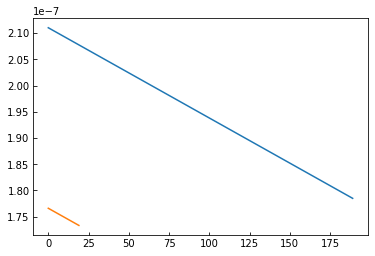

In [182]:
plt.plot(val1[:190])
plt.plot(val1[200:220])

In [22]:
hdulist = pyfits.open(bat_img)
hdulist.info()

Filename: example/S190413a/batfov.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      22   (250, 250)   float64   


In [81]:
hdulist[0].copy

<bound method _ValidHDU.copy of <astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fb156889d90>>

In [30]:
hdulist[0].columns

AttributeError: 'PrimaryHDU' object has no attribute 'columns'

/Users/mcrnogor/opt/anaconda3/lib/python3.7/site-packages/healpy/pixelfunc.py:339: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/mcrnogor/opt/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1134: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/Users/mcrnogor/opt/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1135: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0
/Users/mcrnogor/opt/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/Users/mcrnogor/opt/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/Users/mcrnogor/opt/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between m

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

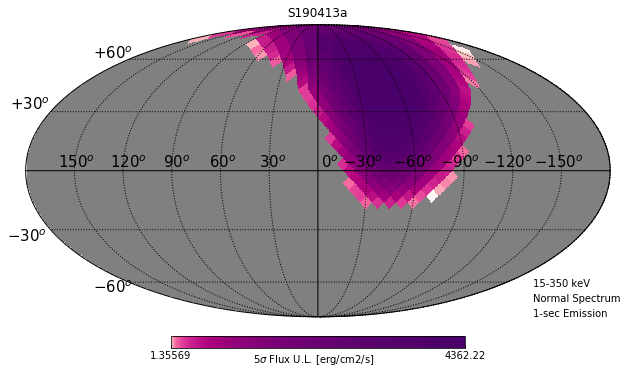

<Figure size 432x288 with 0 Axes>

In [35]:
ul_min = ul_5sigma[12]
ul_max = ul_5sigma[15]

# plotting the BAT FoV
res = .25
nra = int(360. / res)
ndec = int(180. / res)

header = {'NAXIS'  : 2, 'NAXIS1': nra, 'NAXIS2': ndec,
'CTYPE1' : 'RA---MOL',
'CRVAL1' : bat_ra, 'CRPIX1' : int(.5 * nra), 'CUNIT1' : 'deg', 'CDELT1' : -0.25,
'CTYPE2' : 'DEC--MOL',
'CRVAL2' : bat_dec, 'CRPIX2' : int(.5 * ndec), 'CUNIT2' : 'deg', 'CDELT2' : 0.25,
      }

#reprojecting the field of view onto the sky
fits = maputils.FITSimage(bat_img, hdunr=0).reproject_to(header)

# producing a healpy map
nside = 12 # as GBM
npix = hp.nside2npix(nside)
val = np.zeros(npix, np.float64)
th, ph = hp.pix2ang(nside, np.arange(npix))
ra, dec = np.degrees([ph, .5 * np.pi - th])

i, j = fits.proj.topixel((ra, dec))
val = fits.dat[j.astype(int), i.astype(int)]


# vmax = val[~np.isnan(val)].max()
# vmin = val[~np.isnan(val)].min()
# k = (ul_max - ul_min)/(vmax - vmin)
# m = ul_max - k*vmax
# val = k*val+m # rescale FOV map as an upper limit map
# val[np.isnan(val)] = hp.UNSEEN
# val[np.isnan(val)] = hp.UNSEEN
# print("Min: %.3e" % val[val > hp.UNSEEN].min())
# print("Max: %.3e" % val[val > hp.UNSEEN].max())

Earth_limb_region_x = []
Earth_limb_region_y = []

# mask out the Earth
earth_vec = hp.ang2vec(np.radians(90. - earth_dec), np.radians(earth_ra))
earth_pix = hp.query_disc(nside, earth_vec, np.radians(earth_rad))
val[earth_pix] = hp.UNSEEN
plt.figure()
hp.mollview(val, rot=0, fig=3, norm='log', cmap='RdPu', title=event)
hp.graticule()
plt.annotate(r"0$^o$", (0.02, 0.02), size=15)
plt.annotate(r"-30$^o$", (0.31, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"30$^o$", (-0.31, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"-60$^o$", (0.65, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"60$^o$", (-0.65, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"-90$^o$", (0.97, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"90$^o$", (-0.97, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"-120$^o$", (1.30, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"120$^o$", (-1.30, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"-150$^o$", (1.65, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"150$^o$", (-1.65, 0.02), horizontalalignment='center', size=15)
plt.annotate(r"+30$^o$", (-1.97,  0.45), horizontalalignment='center', verticalalignment='center', size=15)
plt.annotate(r"-30$^o$", (-1.99, -0.45), horizontalalignment='center', verticalalignment='center', size=15)
plt.annotate(r"+60$^o$", (-1.40,  0.80), horizontalalignment='center', verticalalignment='center', size=15)
plt.annotate(r"-60$^o$", (-1.40, -0.80), horizontalalignment='center', verticalalignment='center', size=15)
zlabel = r"5$\sigma$ Flux U.L. [erg/cm2/s]"
plt.annotate(zlabel, (0.5, 0.05), horizontalalignment='center', size=10, xycoords='figure fraction')
plt.annotate("15-350 keV", (.85, .25), size=10, xycoords='figure fraction')
plt.annotate("Normal Spectrum", (.85, .21), size=10, xycoords='figure fraction')
plt.annotate("1-sec Emission", (.85, .17), size=10, xycoords='figure fraction')
plt.figure()

In [36]:
len(val)

1728

In [37]:
len(val1)

1728

In [38]:
from scipy.stats import rankdata

In [40]:
val_rank = rankdata(val)

In [41]:
val1_rank = rankdata(val1)

In [70]:
val1_rank

array([1669., 1667., 1664., ..., 1726., 1727., 1728.])

In [75]:
np.where(val_rank==1200)

(array([1348]),)

In [ ]:
val